# Import modules

In [2]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import sys
sys.path.append('../')
from src.config import *
from src.helper_visualization import *
from src.helper_pred import *

# Load Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100402 entries, 0 to 100401
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        100402 non-null  int64 
 1   Title             100402 non-null  object
 2   Product Name      100402 non-null  object
 3   Length            100402 non-null  int64 
 4   Language          100402 non-null  object
 5   Title_Processed   100402 non-null  object
 6   Title_Translated  100402 non-null  object
 7   Title_Enhanced    100402 non-null  object
 8   Tags              100402 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11156 entries, 0 to 11155
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        11156 non-null  int64 
 1   Title             11156 non-null  object
 2   Product Name      111

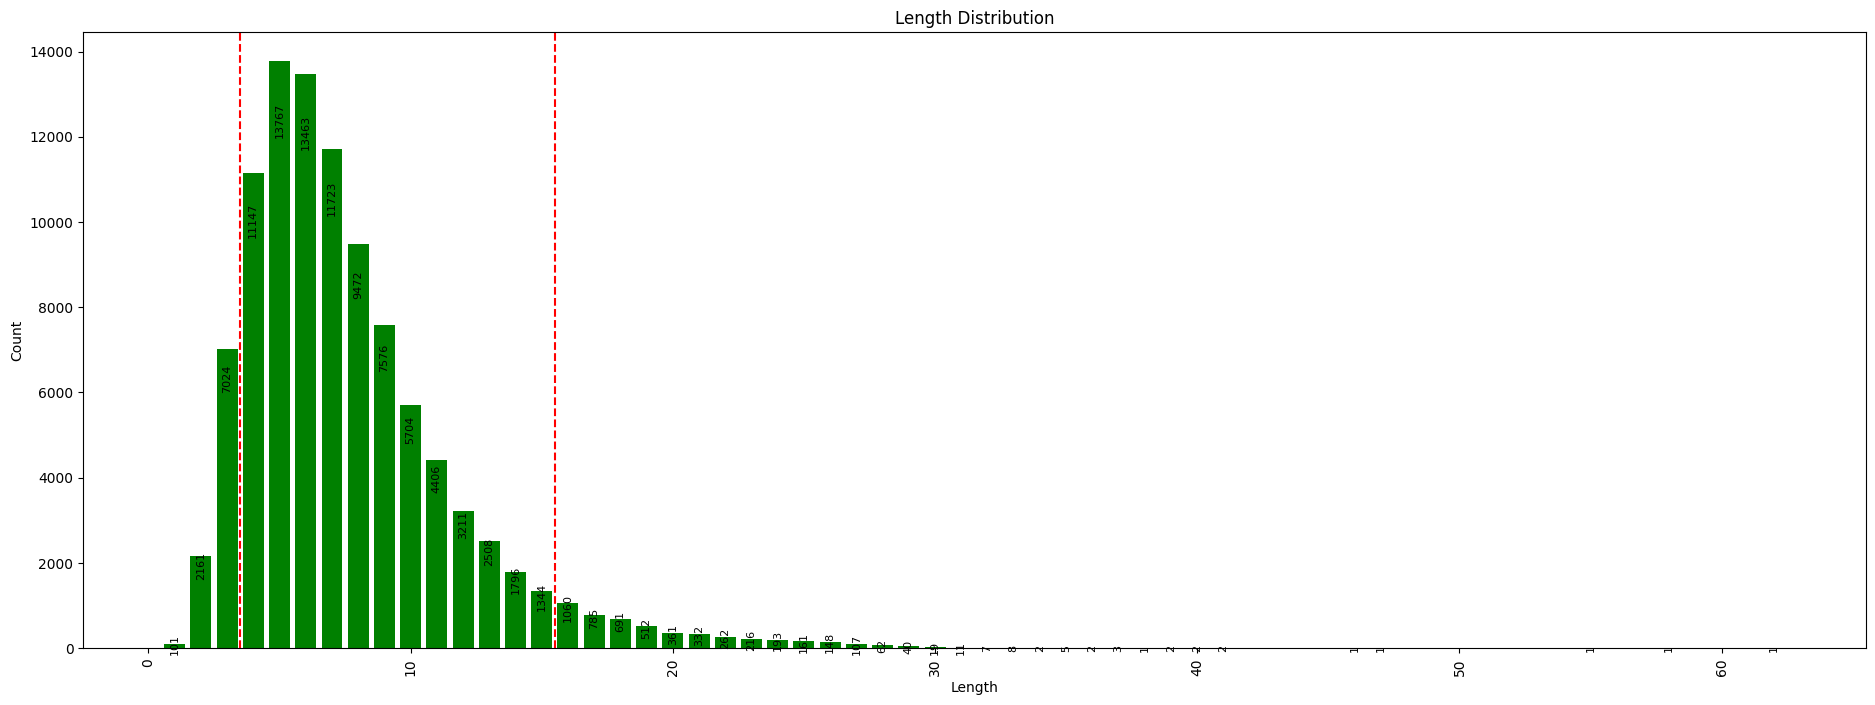

In [3]:
# excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_cleaned.xlsx'
excel_file_train = f'{DATA_FOLDER_PATH_PROCESSED}/data_train.xlsx'
df_train = pd.read_excel(excel_file_train)
excel_file_test = f'{DATA_FOLDER_PATH_PROCESSED}/data_test.xlsx'
df_test = pd.read_excel(excel_file_test)

print(df_train.info())
print(df_test.info())
hist_by_labels(df_train, 'Length', log=False, left=3.5, right=15.5)
hist_by_labels(df_train, 'Product Name', log=True, right=25.5)

# Train/Test Datasets

Pipeline Construction

In [4]:
# Define global variables
TITLE_WORDS_MIN = 3
TITLE_WORDS_MAX = 20
LONGTAIL_CUTOFF = 200

TEXT_COL = 'Title_Enhanced'
TARGET_COL = 'Product Name'

PRODUCT_SIZE_MAX_TRAIN = 2000
PRODUCT_SIZE_MAX_TEST = 300
MAX_FEATURES = 20000

from sklearn.base import BaseEstimator, TransformerMixin

# create a scikit-learn transformer to remove the title with less than 3 words or more than 20 words
class TitleLengthFilter(BaseEstimator, TransformerMixin):
    def __init__(self, min_words=TITLE_WORDS_MIN, max_words=TITLE_WORDS_MAX):
        self.min_words = min_words
        self.max_words = max_words
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        df = X.copy()
        df = df[df['Length'] >= self.min_words]
        df = df[df['Length'] <= self.max_words]
        df = df.reset_index(drop=True)
        return df

# create a scikit-learn transformer to combine the products which have less than 200 samples into one product
class LongTailCombiner(BaseEstimator, TransformerMixin):
    def __init__(self, min_samples=200, target_col=TARGET_COL):
        self.min_samples = min_samples
        self.target_col = target_col
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        df = X.copy()
        counts = df[self.target_col].value_counts()
        long_tails = counts.index[counts < self.min_samples]
        mask = df[self.target_col].isin(long_tails)
        df.loc[mask, self.target_col]='Long Tail'
        return df

# create a scikit-learn transformer to cap the number of samples for each product
class SampleCapper(BaseEstimator, TransformerMixin):
    def __init__(self, max_samples=200, target_col=TARGET_COL):
        self.max_samples = max_samples
        self.target_col = target_col
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        df = X.copy()
        counts = df[self.target_col].value_counts()
        over_sampled = counts.index[counts > self.max_samples]
        # mask = df[self.target_col].isin(over_sampled)
        # df = df.drop(df[mask].sample(frac=1-self.max_samples/len(df)).index)
        for item in over_sampled:
            size = len(df[df[self.target_col]==item])
            df = df.drop(df[df[self.target_col]==item].sample(frac=1-self.max_samples/size).index)
        return df
    
    # create a scikit-learn pipeline to remove the title with less than 3 words or more than 20 words
from sklearn.pipeline import Pipeline

pipleline_data_prep_train = Pipeline([
    ('title_length_filter', TitleLengthFilter(min_words=TITLE_WORDS_MIN, max_words=TITLE_WORDS_MAX)),
    ('long_tail_product_combiner', LongTailCombiner(min_samples=LONGTAIL_CUTOFF, target_col=TARGET_COL)),
    ('sample_capper', SampleCapper(max_samples=PRODUCT_SIZE_MAX_TRAIN, target_col=TARGET_COL)),
    # ('text_vectorizer', TextVectorizer(vectorizer=vectorizer))
])

pipleline_data_prep_test = Pipeline([
    ('title_length_filter', TitleLengthFilter(min_words=TITLE_WORDS_MIN, max_words=TITLE_WORDS_MAX)),
    ('long_tail_product_combiner', LongTailCombiner(min_samples=LONGTAIL_CUTOFF*12//100, target_col=TARGET_COL)),
    ('sample_capper', SampleCapper(max_samples=PRODUCT_SIZE_MAX_TEST, target_col=TARGET_COL)),
    # ('text_vectorizer', TextVectorizer(vectorizer=vectorizer))
])
display(pipleline_data_prep_train)
display(pipleline_data_prep_test)

Pipeline(steps=[('title_length_filter', TitleLengthFilter()),
                ('long_tail_product_combiner', LongTailCombiner()),
                ('sample_capper', SampleCapper(max_samples=2000))])

Pipeline(steps=[('title_length_filter', TitleLengthFilter()),
                ('long_tail_product_combiner',
                 LongTailCombiner(min_samples=24)),
                ('sample_capper', SampleCapper(max_samples=300))])

Data Processing

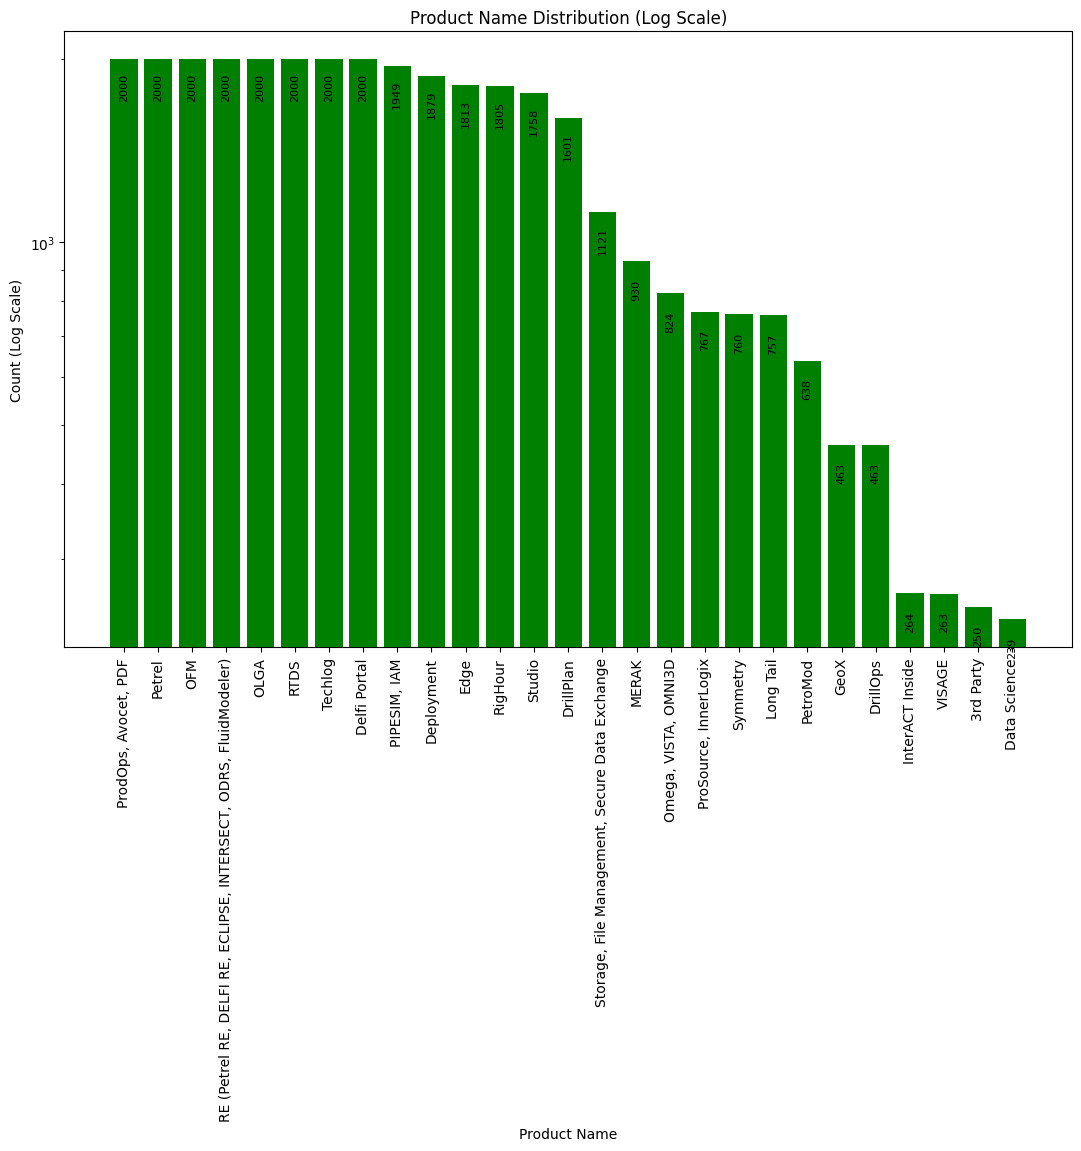

<class 'pandas.core.frame.DataFrame'>
Index: 34544 entries, 7 to 96548
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        34544 non-null  int64 
 1   Title             34544 non-null  object
 2   Product Name      34544 non-null  object
 3   Length            34544 non-null  int64 
 4   Language          34544 non-null  object
 5   Title_Processed   34544 non-null  object
 6   Title_Translated  34544 non-null  object
 7   Title_Enhanced    34544 non-null  object
 8   Tags              34544 non-null  object
dtypes: int64(2), object(7)
memory usage: 2.6+ MB


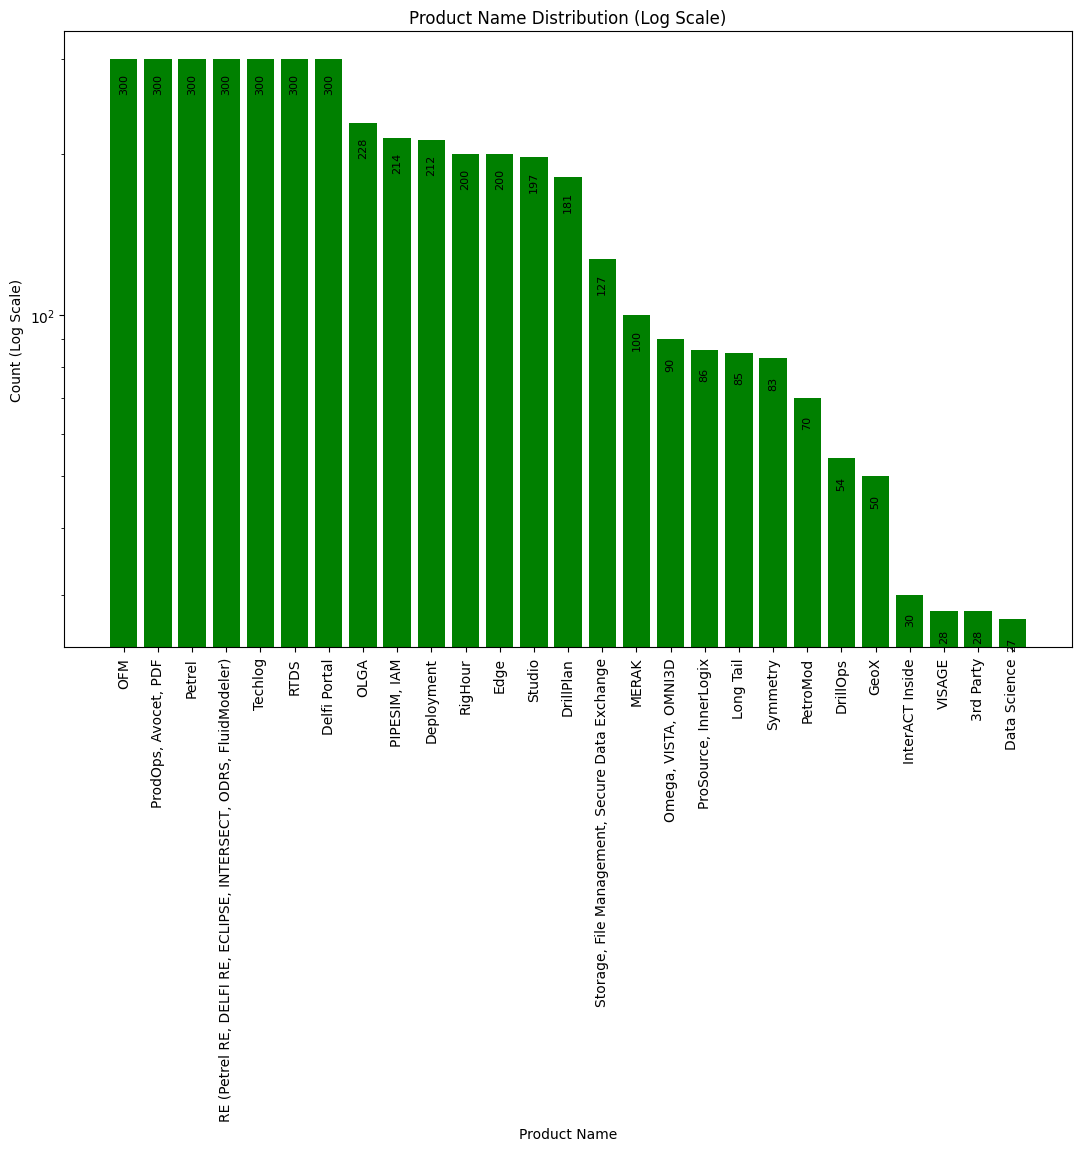

<class 'pandas.core.frame.DataFrame'>
Index: 4390 entries, 1 to 10720
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        4390 non-null   int64 
 1   Title             4390 non-null   object
 2   Product Name      4390 non-null   object
 3   Length            4390 non-null   int64 
 4   Language          4390 non-null   object
 5   Title_Processed   4390 non-null   object
 6   Title_Translated  4390 non-null   object
 7   Title_Enhanced    4390 non-null   object
 8   Tags              4390 non-null   object
dtypes: int64(2), object(7)
memory usage: 343.0+ KB


In [5]:
train_data = pipleline_data_prep_train.fit_transform(df_train)
hist_by_labels(train_data, 'Product Name', log=True, horizontal=True)
train_data.info()

test_data = pipleline_data_prep_test.fit_transform(df_test)
hist_by_labels(test_data, 'Product Name', log=True, horizontal=True)
test_data.info()

# Model Baseline - Cross Validation

In [6]:
# SciKit-Learn
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# Optuna
import optuna
import optuna.visualization as vis

# Others
import pickle

In [7]:
# create vectorizer for text
vectorizer_countvec = CountVectorizer(max_features=MAX_FEATURES, analyzer='word', ngram_range=(1, 2))
vectorizer_tfidf = TfidfVectorizer(max_features=MAX_FEATURES, analyzer='word', ngram_range=(1, 2))

X = df_train[TEXT_COL]
vectorizer_countvec.fit(X)
vectorizer_tfidf.fit(X)

vectorizer = vectorizer_tfidf

X_train = train_data[TEXT_COL]
y_train = train_data[TARGET_COL]
X_train_encoded = vectorizer.transform(X_train)

X_test = test_data[TEXT_COL]
X_test_encoded = vectorizer.transform(X_test)
y_test = test_data[TARGET_COL]

models = {
    'SGDClassifier': SGDClassifier(max_iter=5000),
    'SVC linear': SVC(kernel='linear'),
    'LogisticRegression': LogisticRegression(max_iter=5000),
    # 'RandomForestClassifier': RandomForestClassifier(),
    # 'GradientBoostingClassifier': GradientBoostingClassifier(),
    # 'MultinomialNB': MultinomialNB(),
    # 'SVC rbf': SVC(kernel='rbf'),
}

print('Baseline Score(s) of each model are ....')

for model in models:
    cv_result = cross_val_score(
        models[model], 
        X_train_encoded,
        y_train, #the target
        cv=5, 
        scoring='accuracy', # lease revise to the appropriate score
        n_jobs=-1
    )
    print(f'Average score: \033[94m{"{:.4f}".format(np.mean(cv_result))}\033[0m by \033[94m{model}\033[0m.')

Baseline Score(s) of each model are ....
Average score: 0.7995 by SGDClassifier.
Average score: 0.7931 by SVC linear.
Average score: 0.7845 by LogisticRegression.


# Hpyerparameter Tuning

## SGC Classifier (2min)

In [8]:
# Clean up the study if it exists
study_name = 'sgd_classifier'
storage_name = 'sqlite:///optuna_study.db'

try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass

In [9]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e-3, log=True),
        'eta0': trial.suggest_float('eta0', 1e-3, 1e-1, log=True),
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'adaptive']), #
        'max_iter': 10000,
        'random_state': 42
        }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    sgd_classifier = SGDClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(sgd_classifier, X_train_encoded, y_train, cv=5, scoring='accuracy')
    
    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_sore = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Score:", best_sore)

[I 2023-10-29 12:32:17,853] A new study created in RDB with name: sgd_classifier


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-10-29 12:32:22,375] Trial 7 finished with value: 0.7937993108021953 and parameters: {'alpha': 1.8303294747526452e-06, 'eta0': 0.05613700072413784, 'loss': 'log_loss', 'penalty': 'l2', 'learning_rate': 'optimal'}. Best is trial 7 with value: 0.7937993108021953.
[I 2023-10-29 12:32:23,017] Trial 6 finished with value: 0.8021075537115264 and parameters: {'alpha': 6.870283344514207e-06, 'eta0': 0.02880914002905746, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'constant'}. Best is trial 6 with value: 0.8021075537115264.
[I 2023-10-29 12:32:24,627] Trial 2 finished with value: 0.7859832550595914 and parameters: {'alpha': 2.769459414652349e-06, 'eta0': 0.05722656028332173, 'loss': 'log_loss', 'penalty': 'l1', 'learning_rate': 'optimal'}. Best is trial 6 with value: 0.8021075537115264.
[I 2023-10-29 12:32:26,588] Trial 3 finished with value: 0.7922650004697515 and parameters: {'alpha': 2.9370183636274873e-06, 'eta0': 0.06813414567059045, 'loss': 'log_loss', 'penalty': 'l

In [10]:
vis.plot_optimization_history(study)

In [11]:
vis.plot_slice(study)

Accuracy: 0.810706
                                                                  precision    recall  f1-score   support

                                                       3rd Party      0.636     0.250     0.359        28
                                                    Data Science      0.750     0.667     0.706        27
                                                    Delfi Portal      0.646     0.687     0.666       300
                                                      Deployment      0.738     0.703     0.720       212
                                                        DrillOps      0.936     0.815     0.871        54
                                                       DrillPlan      0.802     0.873     0.836       181
                                                            Edge      0.995     0.980     0.987       200
                                                            GeoX      0.935     0.860     0.896        50
                          

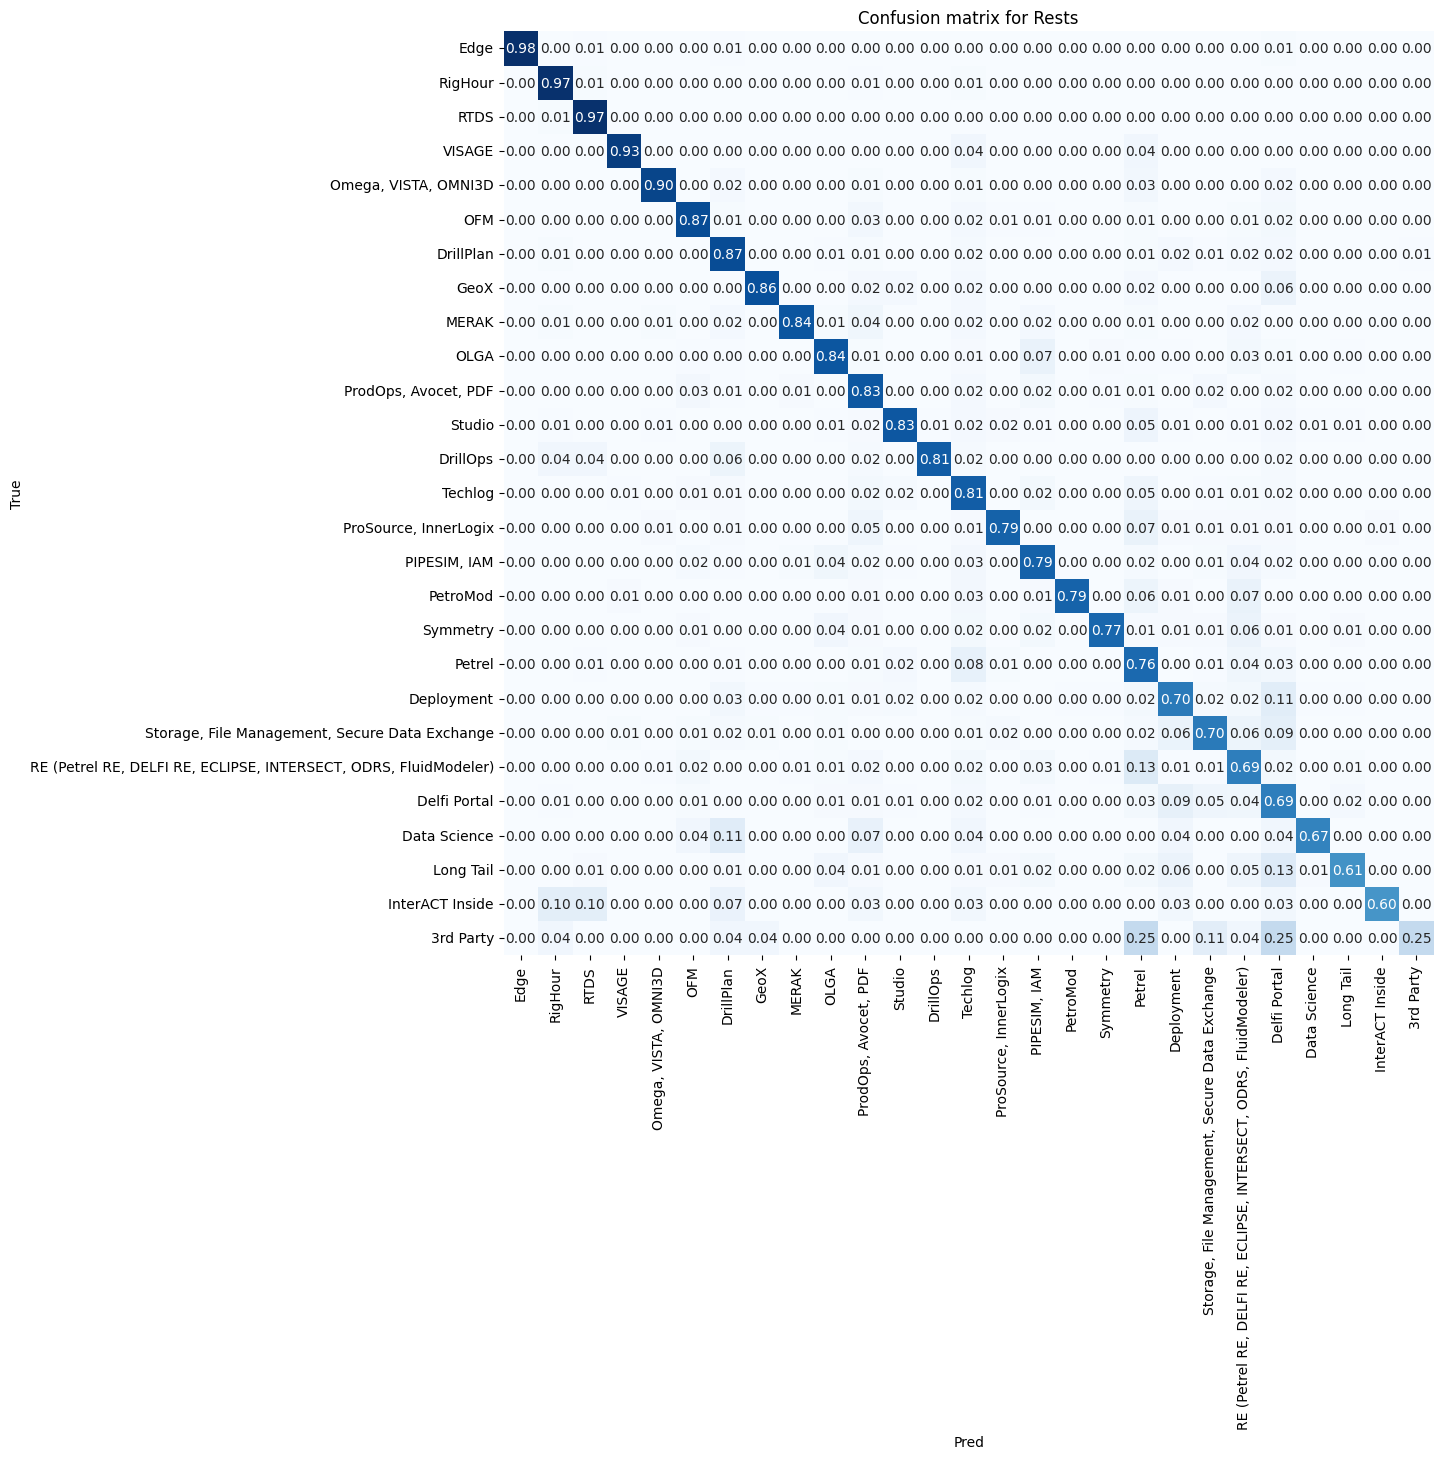

Accuracy of top 1 prediction is 0.811.
Accuracy of top 3 prediction is 0.916.
Accuracy of top 5 prediction is 0.944.


In [12]:
# Create and train the best Logistic Regression model
best_model_sgc = SGDClassifier(**best_params)
best_model_sgc.fit(X_train_encoded, y_train)

# Predict categories for the test data
y_pred_sgc = best_model_sgc.predict(X_test_encoded)

accuracy = accuracy_score(y_test, y_pred_sgc)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

# Evaluate the classifier's performance
print(classification_report(y_test, y_pred_sgc, digits=3))
plot_confusion_matrix(y_test, y_pred_sgc, title='Confusion matrix for Rests')
df_pred_top5_sgc = top5_accuracy_report(best_model_sgc, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [13]:
# export the model
pickle.dump(best_model_sgc, open(f'{MODEL_FOLDER_PATH}/model_sgc_classifier.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_sgc_classifier.pkl', 'wb'))

## Logistic Classification (5min)

In [14]:
# Clean up the study if it exists
study_name = 'logReg'
storage_name = 'sqlite:///optuna_study.db'
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass 

In [15]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga', 'sag']),
        'C': trial.suggest_float('C', 1e-2, 1e+2, log=True),
        'penalty': 'l2',
        'multi_class': 'ovr',
        'max_iter': 50000,
        'random_state': 42
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    logReg = LogisticRegression(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(logReg, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=5, 
    n_jobs=-1, 
    show_progress_bar=True,
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2023-10-29 12:33:21,871] A new study created in RDB with name: logReg


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-10-29 12:33:35,465] Trial 4 finished with value: 0.7261463631393742 and parameters: {'solver': 'sag', 'C': 0.21294900451822515}. Best is trial 4 with value: 0.7261463631393742.
[I 2023-10-29 12:34:14,200] Trial 1 finished with value: 0.7174328265968637 and parameters: {'solver': 'liblinear', 'C': 0.17453372994900634}. Best is trial 4 with value: 0.7261463631393742.
[I 2023-10-29 12:34:52,167] Trial 0 finished with value: 0.7938572272531579 and parameters: {'solver': 'lbfgs', 'C': 1.86615686658653}. Best is trial 0 with value: 0.7938572272531579.
[I 2023-10-29 12:35:06,369] Trial 3 finished with value: 0.8015575213317842 and parameters: {'solver': 'lbfgs', 'C': 4.275655980919988}. Best is trial 3 with value: 0.8015575213317842.
[I 2023-10-29 12:35:09,251] Trial 2 finished with value: 0.8026865296501136 and parameters: {'solver': 'lbfgs', 'C': 5.275223987088216}. Best is trial 2 with value: 0.8026865296501136.
Best Hyperparameters: {'solver': 'lbfgs', 'C': 5.275223987088216}
Best

In [16]:
vis.plot_optimization_history(study)

In [17]:
vis.plot_slice(study)

/Users/haitao/.pyenv/versions/3.11.6/envs/TFT/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Accuracy: 0.8048
                                                                  precision    recall  f1-score   support

                                                       3rd Party      0.600     0.214     0.316        28
                                                    Data Science      0.773     0.630     0.694        27
                                                    Delfi Portal      0.661     0.703     0.682       300
                                                      Deployment      0.729     0.712     0.721       212
                                                        DrillOps      0.935     0.796     0.860        54
                                                       DrillPlan      0.783     0.878     0.828       181
                                                            Edge      1.000     0.975     0.987       200
                                                            GeoX      0.977     0.860     0.915        50
                            

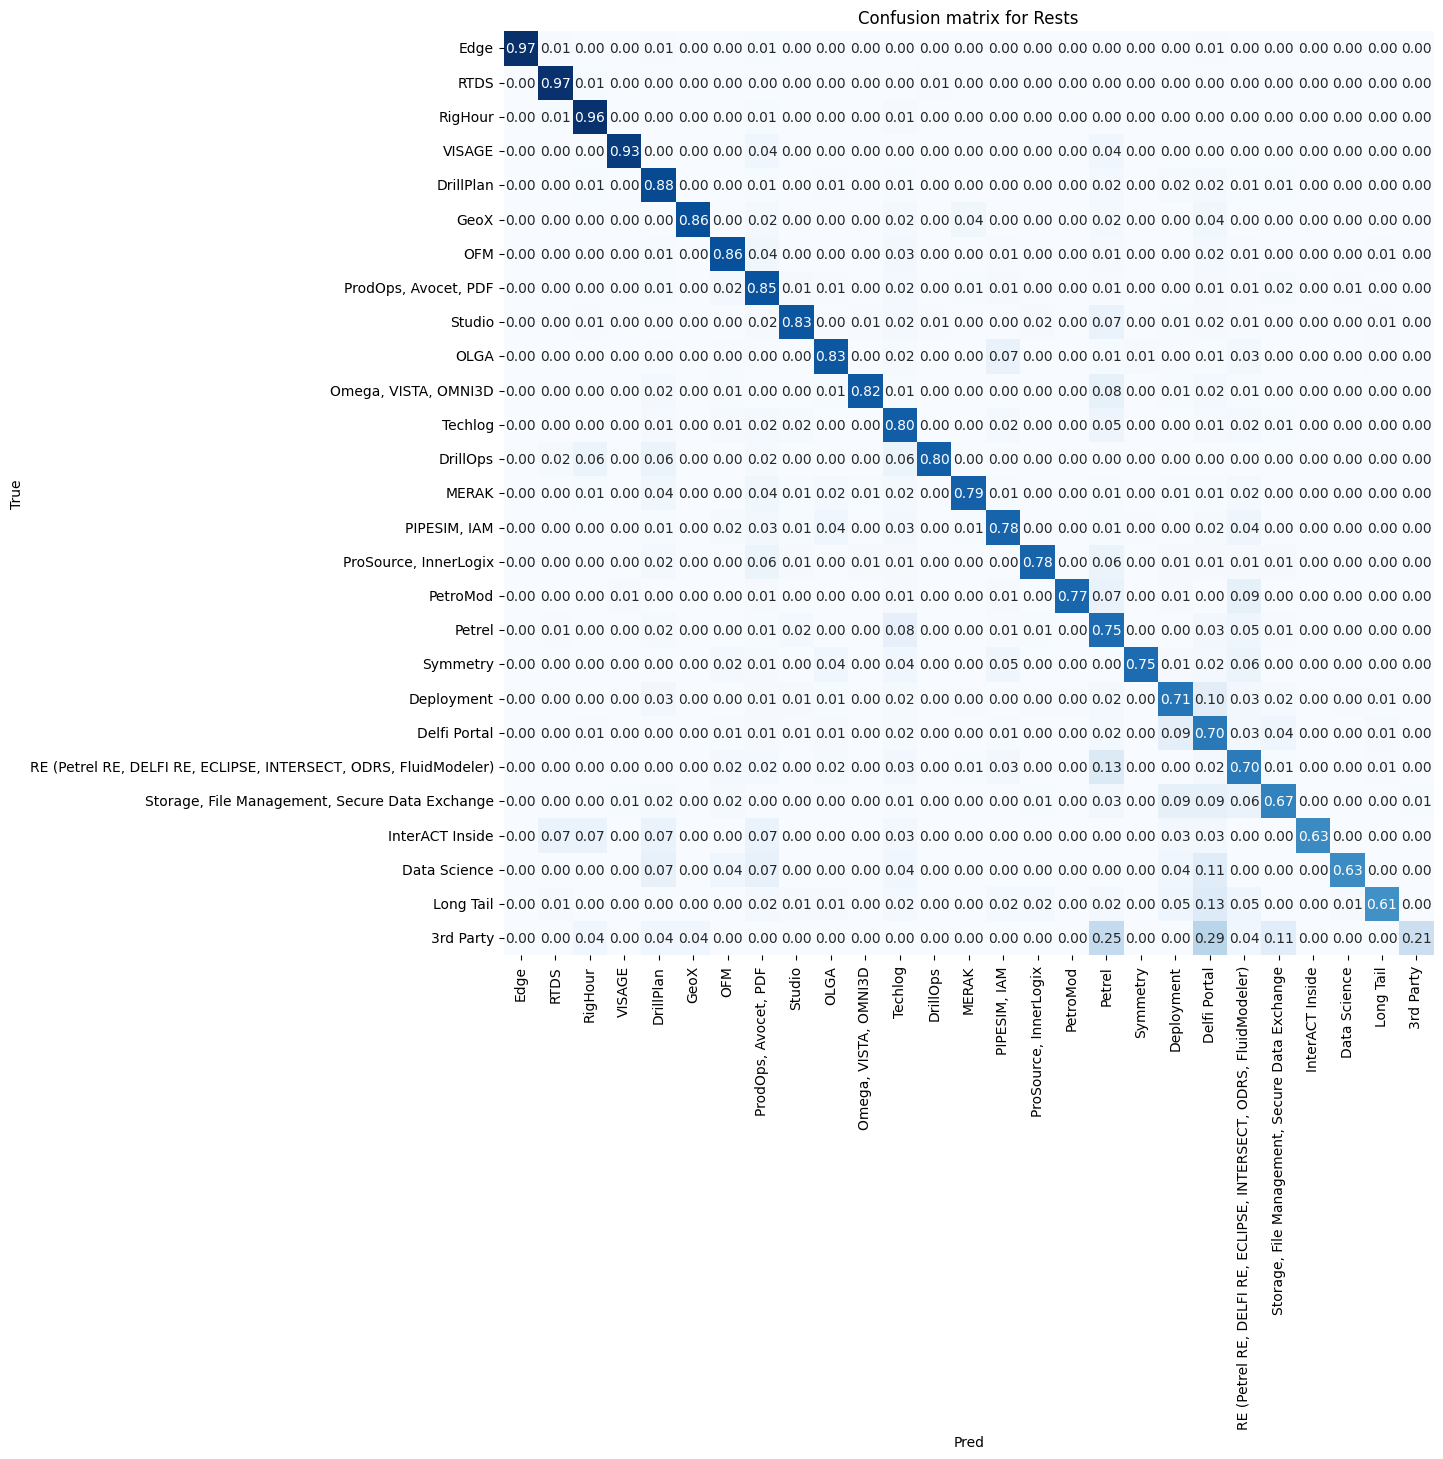

Accuracy of top 1 prediction is 0.805.
Accuracy of top 3 prediction is 0.922.
Accuracy of top 5 prediction is 0.951.


In [18]:
# Create and train the best Logistic Regression model
best_model_logReg= LogisticRegression(**best_params)
best_model_logReg.fit(X_train_encoded, y_train)

# Step 4: Model Evaluation
y_pred_logReg = best_model_logReg.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_logReg)
print(f'Accuracy: \033[94m{accuracy:.4f}\033[0m')

report = classification_report(y_test, y_pred_logReg, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_logReg, title='Confusion matrix for Rests')
df_pred_top5_logReg = top5_accuracy_report(best_model_logReg, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [19]:
# export the model
pickle.dump(best_model_logReg, open(f'{MODEL_FOLDER_PATH}/model_logistic_regression.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_logistic_regression.pkl', 'wb'))

## MultinomialNB (2min)

In [20]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space of MultinomialNB model
    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e+2, log=True),
        'fit_prior': trial.suggest_categorical('fit_prior', [True, False])
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_multinomialNB = MultinomialNB(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_multinomialNB, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=250, 
    n_jobs=-1, 
    show_progress_bar=True,
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value

# Create and train the best Logistic Regression model
best_model_multinomialNB = MultinomialNB(**best_params)
best_model_multinomialNB.fit(X_train_encoded, y_train)
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2023-10-29 12:36:32,968] A new study created in memory with name: no-name-03c20610-6a18-4b6d-8e70-48be762150b0


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2023-10-29 12:36:35,652] Trial 1 finished with value: 0.7161302868299557 and parameters: {'alpha': 0.0008568569176874997, 'fit_prior': False}. Best is trial 1 with value: 0.7161302868299557.
[I 2023-10-29 12:36:35,682] Trial 0 finished with value: 0.7069246888347425 and parameters: {'alpha': 2.627235101053114e-05, 'fit_prior': True}. Best is trial 1 with value: 0.7161302868299557.
[I 2023-10-29 12:36:35,787] Trial 2 finished with value: 0.7162460778272057 and parameters: {'alpha': 0.0008841646750466462, 'fit_prior': False}. Best is trial 2 with value: 0.7162460778272057.
[I 2023-10-29 12:36:35,800] Trial 9 finished with value: 0.7306913190191993 and parameters: {'alpha': 0.6066376568009498, 'fit_prior': True}. Best is trial 9 with value: 0.7306913190191993.
[I 2023-10-29 12:36:35,885] Trial 4 finished with value: 0.7180408885701899 and parameters: {'alpha': 0.0004181055408302954, 'fit_prior': True}. Best is trial 9 with value: 0.7306913190191993.
[I 2023-10-29 12:36:35,963] Trial 3 

Accuracy: 0.771754
                                                                  precision    recall  f1-score   support

                                                       3rd Party      0.417     0.179     0.250        28
                                                    Data Science      0.867     0.481     0.619        27
                                                    Delfi Portal      0.607     0.683     0.643       300
                                                      Deployment      0.685     0.717     0.700       212
                                                        DrillOps      0.812     0.722     0.765        54
                                                       DrillPlan      0.755     0.867     0.807       181
                                                            Edge      0.938     0.990     0.964       200
                                                            GeoX      0.921     0.700     0.795        50
                          

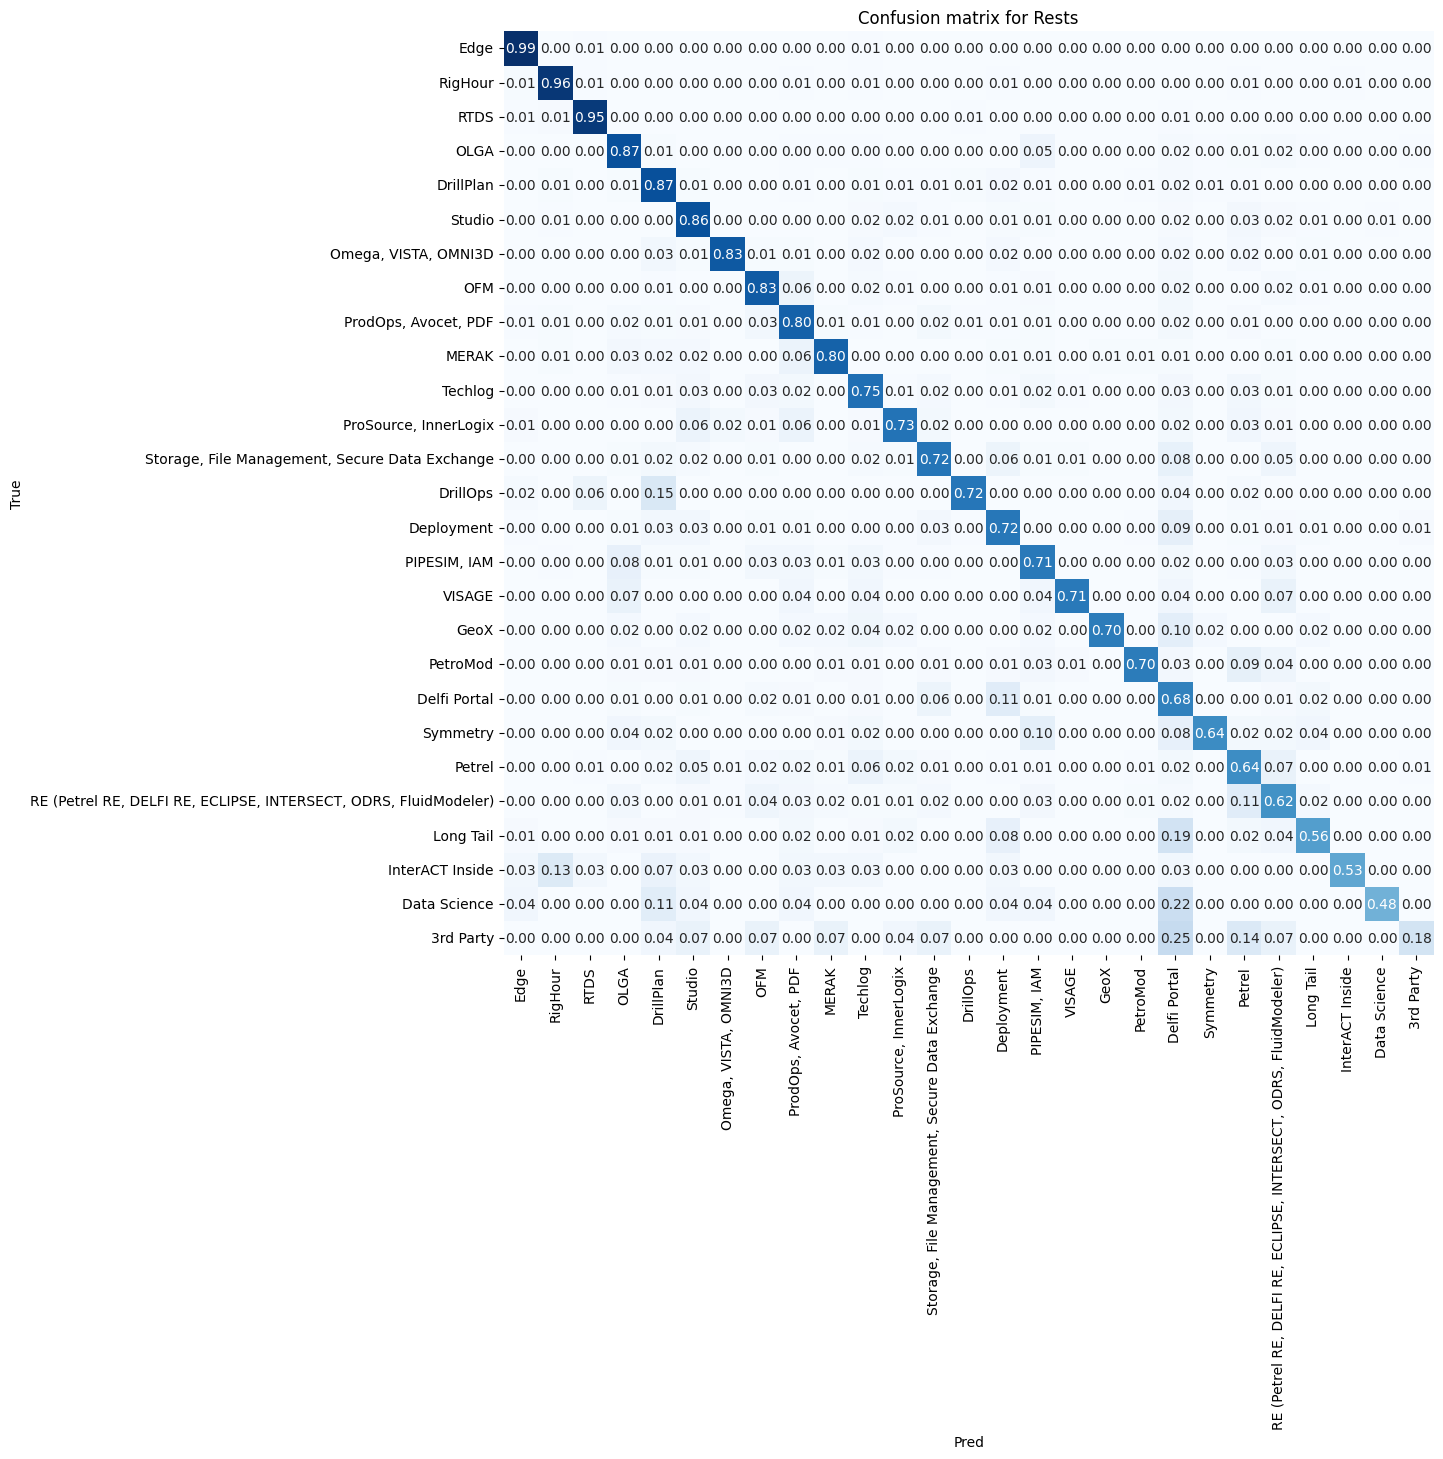

Accuracy of top 1 prediction is 0.772.
Accuracy of top 3 prediction is 0.903.
Accuracy of top 5 prediction is 0.939.


In [22]:
# weights = df_rests['ProductName'].value_counts().apply(np.sqrt).to_dict()
model_multinomialNB = best_model_multinomialNB

# Step 4: Model Evaluation
y_pred_multinomialNB = model_multinomialNB.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_multinomialNB)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

report = classification_report(y_test, y_pred_multinomialNB, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_multinomialNB, title='Confusion matrix for Rests')
df_pred_top5_multinomialNB = top5_accuracy_report(model_multinomialNB, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [23]:
# export the model and the vectorizer
pickle.dump(best_model_multinomialNB, open(f'{MODEL_FOLDER_PATH}/model_multinomialNB.pkl', 'wb'))
pickle.dump(vectorizer_countvec, open(f'{MODEL_FOLDER_PATH}/vectorizer_multinomialNB.pkl', 'wb'))

## SVC Linear (>60min)

In [24]:
# user Optuna to tune the hyperparameters for SVC Linear
study_name = 'SVC_linear'
storage_name = 'sqlite:///optuna_study.db'

# Clean up the study if it exists
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass

In [25]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'C': trial.suggest_float('C', 1, 1.2, log=True),
        'max_iter': 50000,
        'random_state': 42,
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_svc_linear = SVC(kernel='linear', probability=True, **pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_svc_linear, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(
    objective,
    n_trials=5, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)

# Create and train the best Logistic Regression model
best_model_svc_linear = SVC(kernel='linear', **best_params)
best_model_svc_linear.fit(X_train_encoded, y_train)

[I 2023-10-29 12:38:40,294] A new study created in RDB with name: SVC_linear


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-10-29 12:56:56,866] Trial 4 finished with value: 0.7944361612870703 and parameters: {'C': 1.1595990809443644}. Best is trial 4 with value: 0.7944361612870703.
[I 2023-10-29 12:57:00,045] Trial 3 finished with value: 0.7937413817798307 and parameters: {'C': 1.1104362615886665}. Best is trial 4 with value: 0.7944361612870703.
[I 2023-10-29 12:57:03,769] Trial 1 finished with value: 0.7935098207376681 and parameters: {'C': 1.0551630051064582}. Best is trial 4 with value: 0.7944361612870703.
[I 2023-10-29 12:57:06,547] Trial 2 finished with value: 0.7943782657884453 and parameters: {'C': 1.1639117478844785}. Best is trial 4 with value: 0.7944361612870703.
[I 2023-10-29 12:57:07,102] Trial 0 finished with value: 0.7941756147813879 and parameters: {'C': 1.1364872232533114}. Best is trial 4 with value: 0.7944361612870703.
Best Hyperparameters: {'C': 1.1595990809443644}


NameError: name 'X_train_tfidf' is not defined

In [27]:
vis.plot_optimization_history(study)

In [28]:
vis.plot_slice(study)

Accuracy: 0.801822
                                                                  precision    recall  f1-score   support

                                                       3rd Party      0.583     0.250     0.350        28
                                                    Data Science      0.760     0.704     0.731        27
                                                    Delfi Portal      0.600     0.730     0.659       300
                                                      Deployment      0.771     0.698     0.733       212
                                                        DrillOps      0.957     0.815     0.880        54
                                                       DrillPlan      0.758     0.867     0.809       181
                                                            Edge      1.000     0.970     0.985       200
                                                            GeoX      0.956     0.860     0.905        50
                          

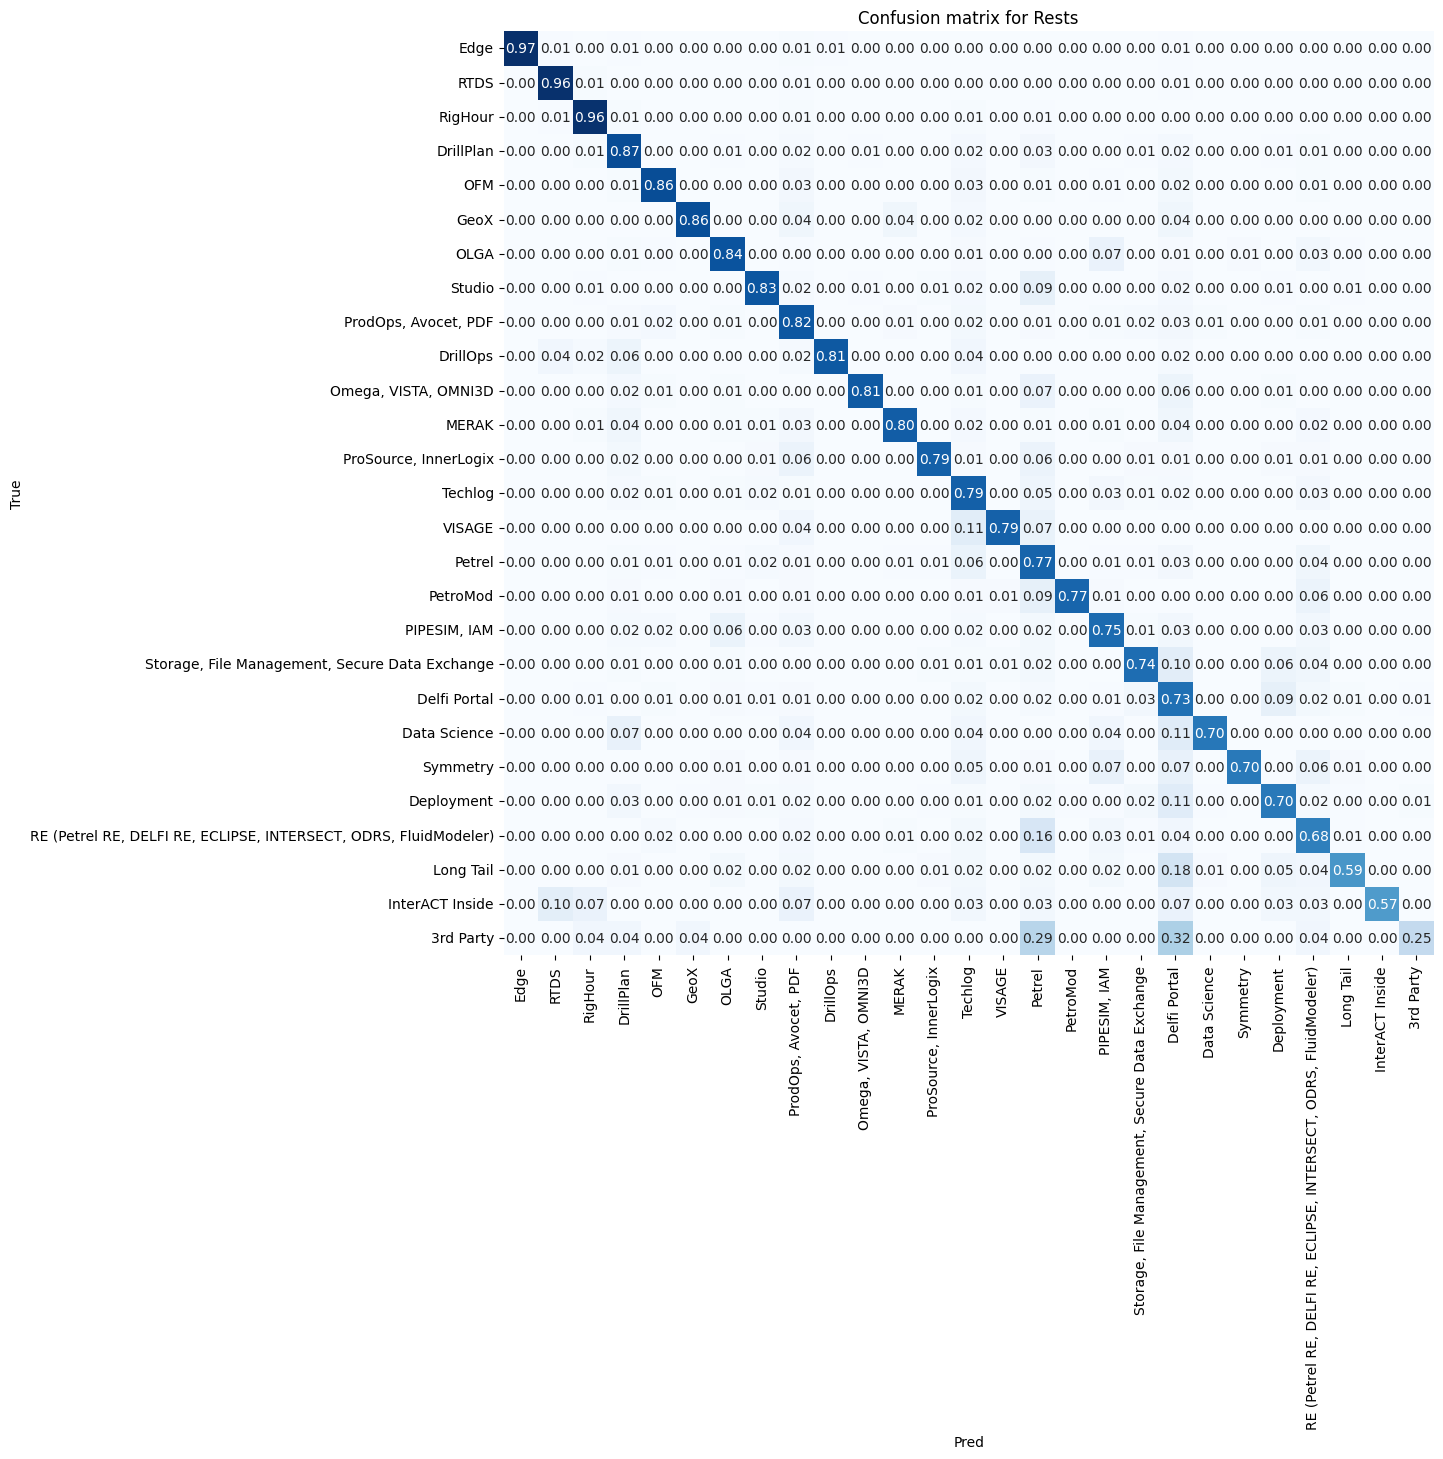

Accuracy of top 1 prediction is 0.807.
Accuracy of top 3 prediction is 0.924.
Accuracy of top 5 prediction is 0.952.


In [30]:
best_model_svc_linear = SVC(kernel='linear', probability=True, **best_params)
# best_model_svc_linear = SVC(kernel='linear', probability=True)
best_model_svc_linear.fit(X_train_encoded, y_train)

# Step 4: Model Evaluation
y_pred_svc_linear = best_model_svc_linear.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_svc_linear)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

report = classification_report(y_test, y_pred_svc_linear, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_svc_linear, title='Confusion matrix for Rests')
df_pred_top5_svc_linear = top5_accuracy_report(best_model_svc_linear, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [31]:
pickle.dump(best_model_svc_linear, open(f'{MODEL_FOLDER_PATH}/model_svc_linear.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_svc_linear.pkl', 'wb'))

## RandomForestClassifier

In [ ]:
# user Optuna to tune the hyperparameters for RandomForestClassifier

# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 4000, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        # 'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        # 'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_random_forest = RandomForestClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_random_forest, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value
print("Best Hyperparameters:", best_params)

best_model_random_forest = RandomForestClassifier(**best_params)
best_model_random_forest.fit(X_train_encoded, y_train)

# Step 4: Model Evaluation
y_pred_random_forest = best_model_random_forest.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_random_forest)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

report = classification_report(y_test, y_pred_random_forest, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_random_forest, title='Confusion matrix for Rests')
df_pred_top5_random_forest = top5_accuracy_report(best_model_random_forest, vectorizer_tfidf, X_test, y_test, pre_processed=True)

pickle.dump(best_model_random_forest, open(f'{MODEL_FOLDER_PATH}/model_random_forest.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_random_forest.pkl', 'wb'))

## Voting model

/Users/haitao/.pyenv/versions/3.11.6/envs/TFT/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8112
                                                                  precision    recall  f1-score   support

                                                       3rd Party      0.538     0.250     0.341        28
                                                    Data Science      0.750     0.778     0.764        27
                                                    Delfi Portal      0.660     0.723     0.690       300
                                                      Deployment      0.743     0.708     0.725       212
                                                        DrillOps      0.938     0.833     0.882        54
                                                       DrillPlan      0.787     0.878     0.830       181
                                                            Edge      0.995     0.980     0.987       200
                                                            GeoX      0.956     0.860     0.905        50
                            

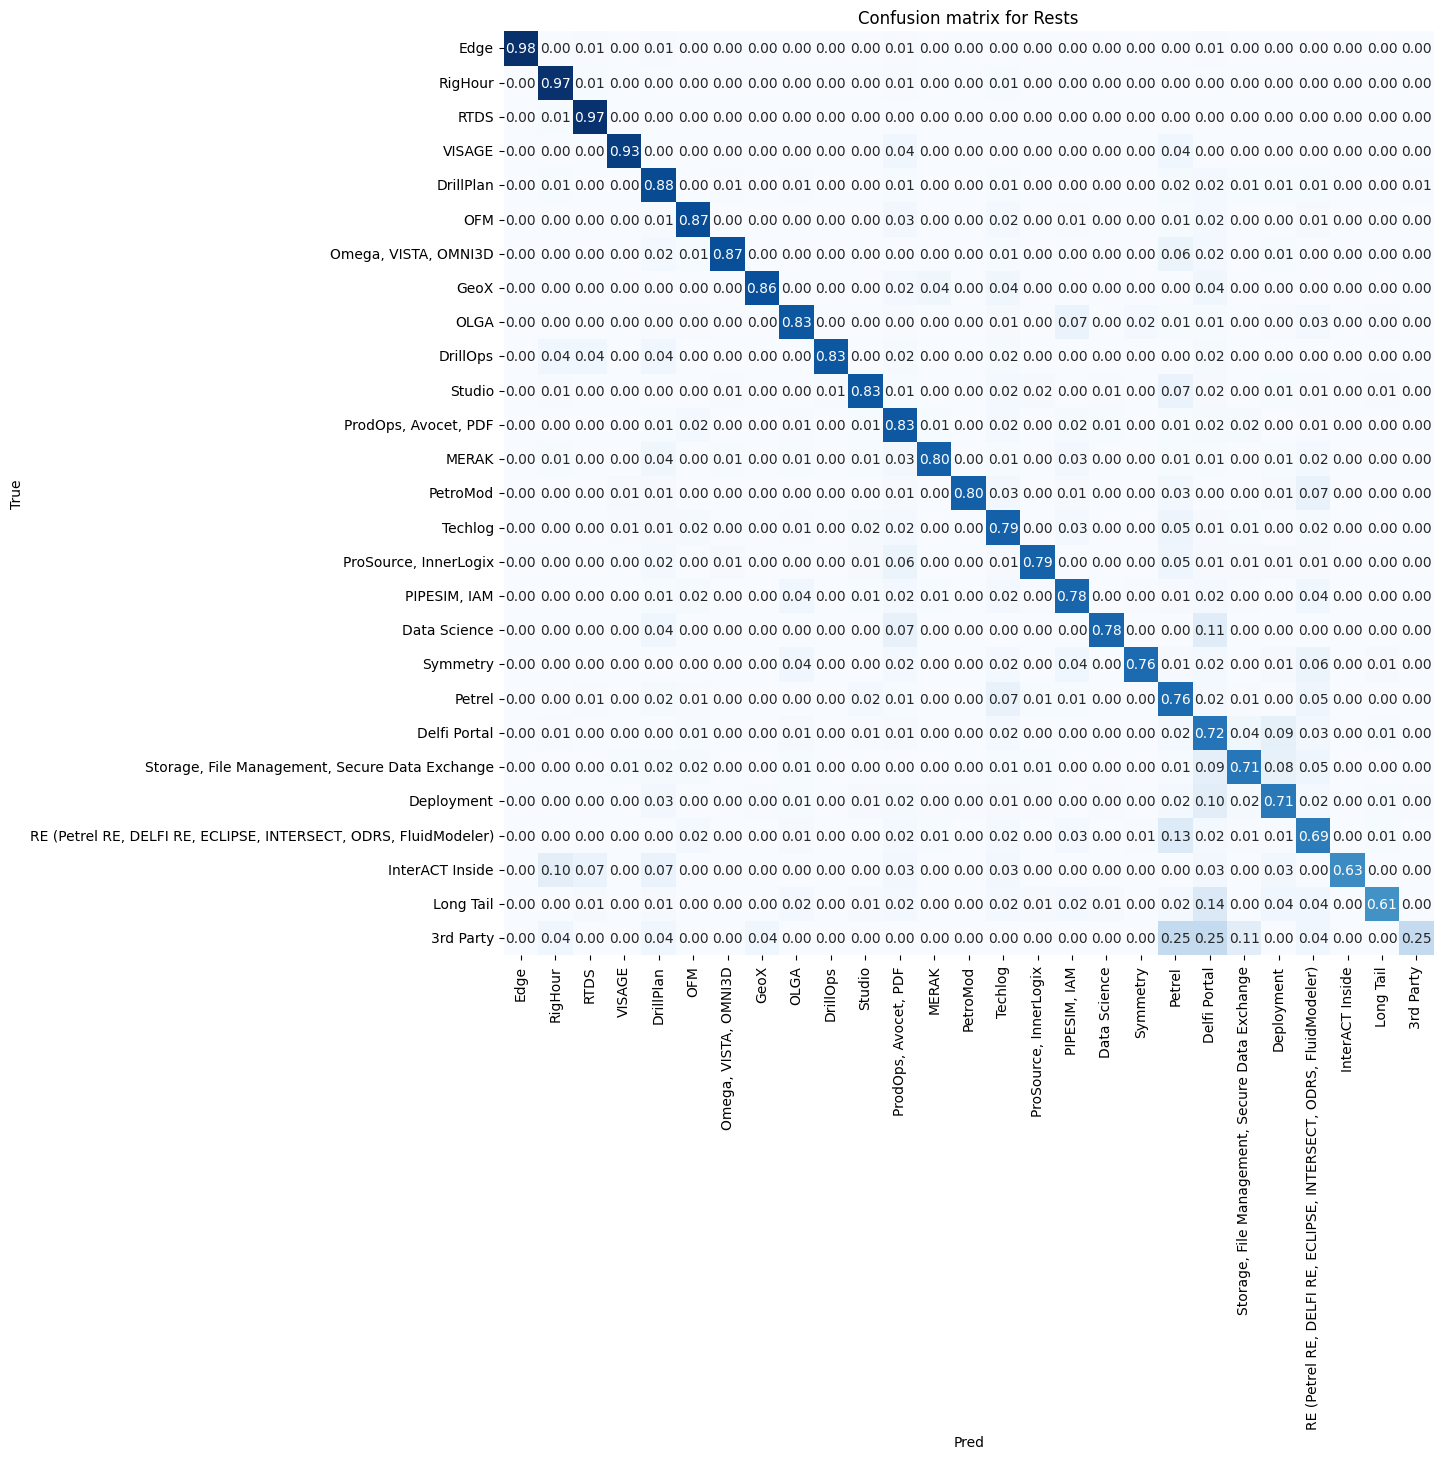

Accuracy of top 1 prediction is 0.811.
Accuracy of top 3 prediction is 0.925.
Accuracy of top 5 prediction is 0.950.


In [33]:
# now we have three models, logistic regression, multinomialNB and svc_linear, we can use voting classifier to combine them together
from sklearn.ensemble import VotingClassifier

# Create a dictionary of the models
estimators = [
    ('logReg', best_model_logReg),
    ('svc_linear', best_model_svc_linear),
    ('sgc_classifier', best_model_sgc),
]

# Create a voting classifier
voting = VotingClassifier(estimators, voting='soft', n_jobs=-1)

# Fit the voting classifier to the training data
voting.fit(X_train_encoded, y_train)

# Step 4: Model Evaluation
y_pred_voting = voting.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_voting)
print(f'Accuracy: \033[94m{accuracy:.4f}\033[0m')

report = classification_report(y_test, y_pred_voting, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_voting, title='Confusion matrix for Rests')

df_pred_top5_voting = top5_accuracy_report(voting, vectorizer, X_test, y_test, pre_processed=True)

In [ ]:
pickle.dump(voting, open(f'{MODEL_FOLDER_PATH}/model_voting.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_voting.pkl', 'wb'))